- Launch as slides with 

```bash
$ jupyter nbconvert --to slides week4-systems-of-nonlinear-equations.ipynb --post serve --TemplateExporter.extra_template_basedirs=${PWD}/slide_templates/ --template revealx
```

What is the first Newton step $\Delta \mathbf{x}_1$ of the non-linear system of equations

$\displaystyle F\left({ x \atop y }\right) = \left[ { {x^3 + y - 1} \atop { y^3 - x + 1 } } \right] = 0$

with $\mathbf{x}_0 = [0 \; 0]^\mathrm{T}$?

In [1]:
try:
    from bokeh.themes import Theme
except ImportError:
    print('bokeh required!\nInstall it with\n$ pip install bokeh')

In [2]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 5]

from bokeh.themes import Theme
from bokeh.models.widgets.inputs import AutocompleteInput
from bokeh.models.widgets import (PreText, Div, Switch, Dropdown,
                                  RangeSlider, Slider, TextInput,
                                  MultiSelect, MultiChoice,
                                  RadioButtonGroup, Button,
                                  Toggle)

from bokeh.models import Range1d, Span

# from bokeh.models import Switch, Dropdown
from bokeh.layouts import column, row, layout
from bokeh.plotting import curdoc, figure, show

from bokeh.io import output_notebook

In [3]:
# If the previous cell raised a message, set the line below with the port as indicated
import os

os.environ['BOKEH_ALLOW_WS_ORIGIN'] = 'localhost:8888,localhost:8889,127.0.0.1:8000'

# Load this notebook as the bokeh server
output_notebook()

Loading BokehJS ...

# Non-linear equations: II

Systems of nonlinear equations tend to be more difficult to solve than single non- linear equations for a number of reasons:
- A much wider range of behavior is possible, so that a theoretical analysis of the existence and number of solutions is much more complex.
- With conventional numerical methods, there is no simple way, in general, of bracketing a desired solution to produce an absolutely safe method with guaranteed convergence. 
- Computational overhead increases rapidly with the dimension
of the problem.

## But first

Perhaps the most important competence to pick up from the lessons this week (and next week):

- While we have access to excellent libraries with standard procedures, understanding what goes on inside still important
- Even before that: the details of how one formulates a problem (e.g. the form of the $f(x) = 0$ to solve for) are very important
  - Often referred to as pre-conditioning

What is the first Newton step of the non-linear system of equations

$\displaystyle F\left({ x \atop y }\right) = \left[ { {x^3 + y - 1} \atop { y^3 - x + 1 } } \right] = 0$



## System of non-linear equations

$\displaystyle F(x) = \left[ { y_1 \atop y_2 } \right] = \left[ { {x_1 + 2x_2 - 2} \atop {x_1^2 + 4x_2^2 -4} } \right] = 0$

$\displaystyle J = F^\prime(x) = \left[ { { 1 \;\;\; 2 } \atop {2x_1 ~~ 8x_2 } } \right]$ 

In [4]:
def func(x):
    return np.array([x[0] + 2*x[1] - 2, 
                     x[0]**2 + 4*x[1]**2 - 4])
def jac(x):
    return np.array([[1, 2], 
                     [2*x[0], 8*x[1]]])

In [5]:
N = 128
xarr = np.linspace(-3,3,128)
xi, yi = np.meshgrid(xarr, xarr)
sh = xi.shape
X = np.array([xi.flatten(), yi.flatten()])
Fx = func(X)

def plot_nonlinear_system():
    fig, ax = plt.subplots(1,1)

    for ind in [0,1]:
        CS = ax.contour(X[0].reshape(sh), X[1].reshape(sh), Fx[ind].reshape(sh), [0],
                        colors=['k'], alpha=0.8)
        
        cl = ax.clabel(CS, CS.levels, fmt={0:r'$y_{ind}=0$'.replace('ind', f'{ind+1}')},
                       inline=True, fontsize=10)
    
        ax.contourf(X[0].reshape(sh), X[1].reshape(sh), Fx[ind].reshape(sh), [-2,0,2],
                    colors=['0.8','0.1'], alpha=0.3, zorder=-100)
    
    ax.grid(); ax.set_xlabel(r'$x_1$'); ax.set_ylabel(r'$x_2$')
    return fig, ax

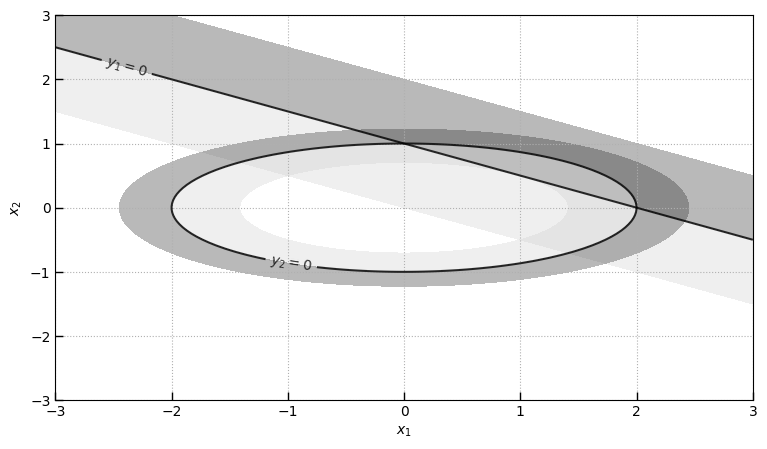

In [6]:
fig, ax = plot_nonlinear_system()

# Newton algorithm in *N*-dimensions

Again, requires that you can calculate both the function $F$ and it's derivative $F^\prime$, the Jacobian *matrix*.

$\Delta x_k = -f(x_k) / f^\prime(x_k)$

In [7]:
def newton_step(xk, damp=1, tol=1.e-12):
    sk = np.linalg.solve(jac(xk), -func(xk))
    if np.linalg.norm(sk, ord=np.inf) < tol:
        return xk, None

    xk1 = xk + sk
    return xk1, sk

In [8]:
def show_newton(x0=[1,2]):
    fig, ax = plot_nonlinear_system()

    xprev = x0
    
    for i in range(30):
        xk, sk = newton_step(xprev)
        if sk is None:
            print(f'Newton stopped after {i} steps: xk = [{xk[0]:.3e} {xk[1]:.3e}]')
            break
            
        ax.plot(*np.array([xprev, xk]).T, color='r', marker='.',alpha=0.2, markersize=15, linewidth=3)
        xprev = xk

Newton stopped after 6 steps: xk = [1.503e-16 1.000e+00]


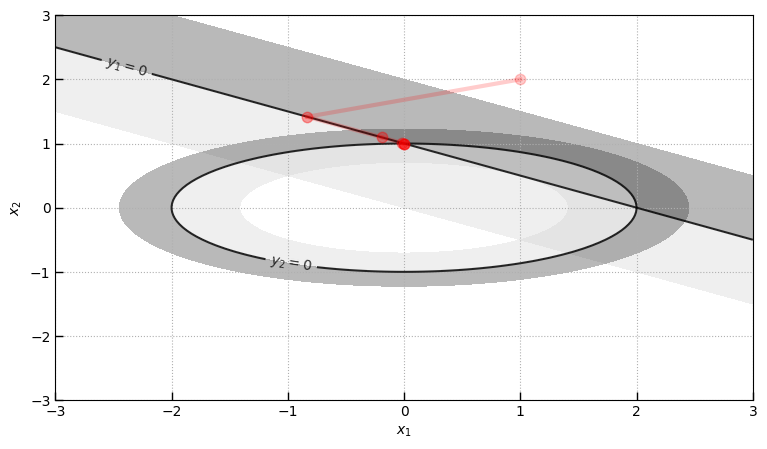

In [9]:
show_newton(x0=[1,2])

# Secant-Updating with the Broyden update

In [10]:
def broyden_step(xk, Bk, tol=1.e-12):
    sk = np.linalg.solve(Bk, -func(xk))
    if np.linalg.norm(sk, ord=np.inf) < tol:
        return xk, Bk, None

    xk1 = xk + sk
    yk = func(xk1) - func(xk)
    dB = np.outer(yk - Bk@sk, sk) / (sk.T @ sk)

    Bk1 = Bk + dB
    return xk1, Bk1, dB

In [11]:
def show_broyden(x0=[1,2]):
    fig, ax = plot_nonlinear_system()

    Bk = jac(x0)
    xprev = x0
    
    for i in range(30):
        xk, Bk, dB = broyden_step(xprev, Bk)
        if dB is None:
            print(f'Broyden stopped after {i} steps: xk = [{xk[0]:.3e} {xk[1]:.3e}]')
            break
            
        ax.plot(*np.array([xprev, xk]).T, color='r', marker='.',alpha=0.2, markersize=15, linewidth=3)
        xprev = xk

Broyden stopped after 8 steps: xk = [8.425e-17 1.000e+00]


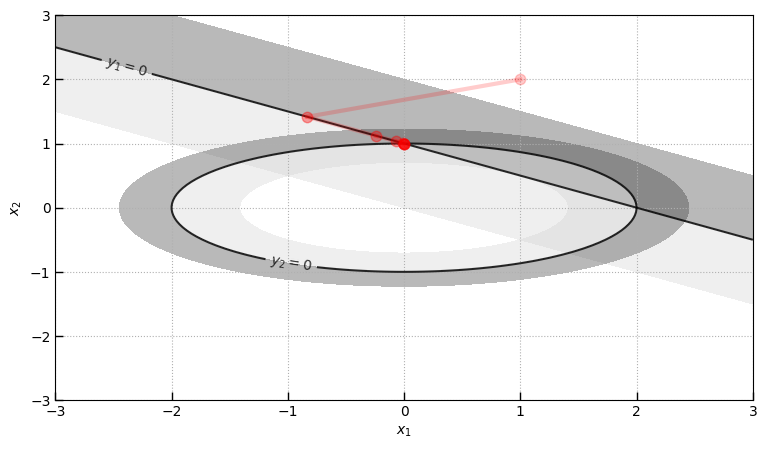

In [12]:
show_broyden(x0=[1,2])

Broyden stopped after 8 steps: xk = [2.000e+00 5.423e-17]


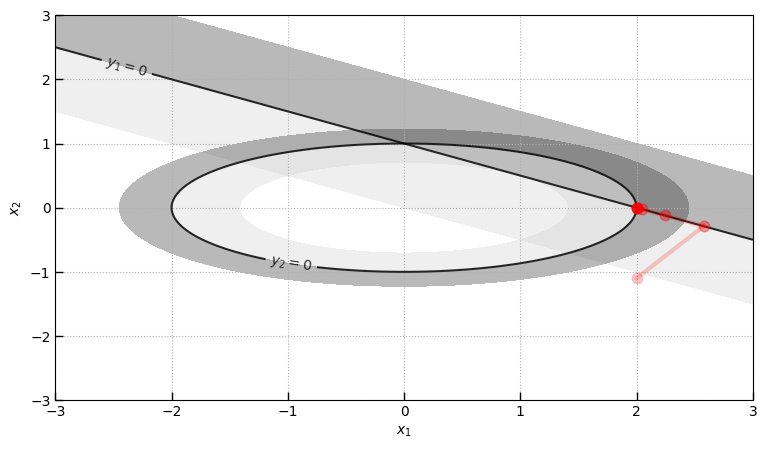

In [13]:
show_broyden(x0=[2, -1.1])

Broyden stopped after 7 steps: xk = [2.000e+00 -7.512e-14]


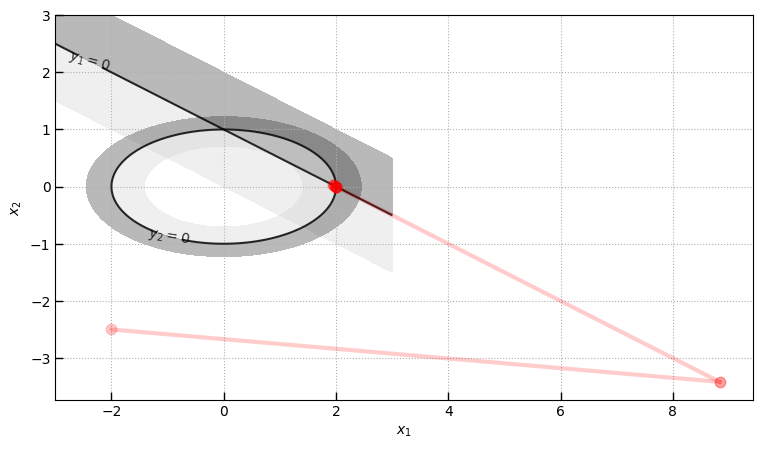

In [14]:
show_broyden(x0=[-2, -2.5])